In [18]:
# Install Ultralytics for YOLO and DeepSort for tracking
!pip install ultralytics deep-sort-realtime

In [19]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>


0: 480x640 8 persons, 230.5ms
Speed: 3.6ms preprocess, 230.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


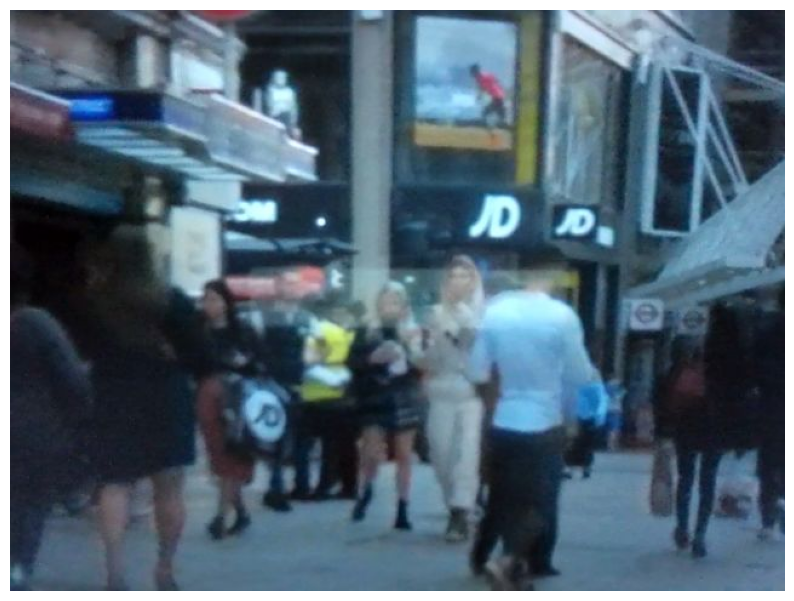

In [20]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# 1. Initialize YOLOv8 (Detector) and Deep SORT (Tracker)
model = YOLO('yolov8n.pt')
tracker = DeepSort(max_age=30)

# 2. Capture a frame from webcam
image_file = take_photo()
frame = cv2.imread(image_file)

# 3. Object Detection
results = model(frame)[0]
detections = []

for r in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = r
    # Filter for high confidence detections
    if score > 0.5:
        # DeepSORT expects [left, top, w, h]
        detections.append([[x1, y1, x2 - x1, y2 - y1], score, int(class_id)])

# 4. Update Tracker
tracks = tracker.update_tracks(detections, frame=frame)

# 5. Draw Results
for track in tracks:
    if not track.is_confirmed():
        continue

    track_id = track.track_id
    ltrb = track.to_ltrb() # Get Left-Top-Right-Bottom coords

    cv2.rectangle(frame, (int(ltrb[0]), int(ltrb[1])), (int(ltrb[2]), int(ltrb[3])), (0, 255, 0), 2)
    cv2.putText(frame, f"ID: {track_id}", (int(ltrb[0]), int(ltrb[1]-10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# 6. Display Output
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()